**This functions have been moved to jupypft.attachmentRateCFT**

In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact_manual
import ipywidgets as wd

from math import floor, log10
from os import system

''' GLOBAL CONSTANTS '''
PI = 3.141592
BOLTZMANN = 1.380649E-23 #N·m/K
TEMP = 10 + 273.15 #K
g = 9.81 #m/s²

def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if exponent is None:
        exponent = int(floor(log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return r"${0:.{2}f}\times10^{{{1:d}}}$".format(coeff, exponent, precision)


# Calculate the attachment coefficient via filtration theory

## Our model:

\begin{equation}
\begin{array}{rr}
    \dfrac{\partial C}{\partial t} + \dfrac{1}{\theta}\:\vec{q} \cdot \nabla C  - \nabla \cdot (D_T\nabla C) =& - k_{\rm att}C + \dfrac{1}{\theta}k_{\rm det}S -\lambda_{\rm aq} C\\
    \\
    \dfrac{1}{\theta}\dfrac{\partial S}{\partial t} =& k_{\rm att}C - \dfrac{1}{\theta}k_{\rm det}S -\lambda_{\rm im} S\\
\end{array}
\end{equation}

**Concentrations**
- $C$ : concentration of infective viruses in the water phase
- $S$ : concentration of infective viruses attached to the solid phase

**Reaction rates**
- $k_{\rm att}$ : attachment rate (C -> S)
- $k_{\rm det}$ : detachment rate (S -> C)
- $\lambda_{\rm aq}$ : decay rate while in aqueous phase (C -> X)
- $\lambda_{\rm im}$ : decay rate while attached to solid phase (S -> X)

**Advection/diffusion parameters**
- $\vec{q}$ : darcy velocity
- $t$ : time
- $\theta$ : porosity
- $D_T$ : Dispersion coefficient

### Dispersion coefficient $D_T$

$ D_T = D_m + \alpha_LU^n $

- $D_m$ : molecular diffusion coefficient
- $\alpha_L$ : longitudinal dispersion coefficient
- $U$ : intersticial flow velocity
- $n$ : empirical fitting exponent

*Neglecting transversal dispersion*b

In [2]:
def dispCoef(D_m,alpha_L,U,n=1.0): 
    return D_m + alpha_L*(U**n)

### Intersticial flow velocity $U$

Pore-water velocity from the darcy velocity:

$\vec{U} = \dfrac{\vec{q}}{\theta}$

In [3]:
def poreVel(q,theta): 
    return q/theta

### Molecular diffusion coefficient $D_m$

From the Stokes-Einstein equation:

$D_m = \dfrac{k_BT}{3\pi\eta d_p}$

- $T$ : Temperature
- $k_B$ : Boltzmann constant
- $\eta$ : water dynamic viscosity
- $d_p$ : (virus) particle diameter
_____

In [4]:
def molecularDiff(visco,dp): 
    return (BOLTZMANN*TEMP)/(3*PI*visco*dp)

## Attachment rate coefficient: $k_{\rm att}$

\begin{equation}
    k_{\rm att} = \dfrac{3 }{2d}(1-\theta)\alpha||\vec{U}||\eta_0
\end{equation}

- $d$ : collector diameter (soil grain size)
- $\alpha$ : collision/attachment efficiency
- $\eta_0$ : collector efficiency

In [5]:
def attachmentRate(dc,theta,alpha,U,eta0): 
    return (3*(1-theta)*alpha*U*eta0)/(2*dc)

### Collision/attachment efficiency $\alpha$

\begin{equation}
    \alpha = 
    \dfrac{\text{Rate at which particles attach to the collector}}
        {\text{Rate at which particles collide with the collector}}
\end{equation}

$\alpha = 1.0$ for **favorable attachment conditions**, e.g., opposed electrostatic charges between the collector (soil grains) and the particles.

For **infavorable conditions** such as the movement of viruses in soils, $\alpha < 1.0$. In these cases, it will be dependant of the isoelectric point of the particles and the soil matrix. 

### The collector efficiency: $\eta_0$

$
    \eta_0 = \overbrace{\eta_{\rm D}}^\text{Diffusion} + \underbrace{\eta_{\rm I}}_\text{Interception} + \overbrace{\eta_{\rm G}}^\text{Grav. deposition}
$

In [6]:
def collectorEff(etaD,etaI,etaG):
    return etaD + etaI + etaG

Each term is approximated by Tufenkji & Elimelech (2004) [\[10.1021/es034049r\]](https://pubs.acs.org/doi/10.1021/es034049r):

$
\begin{array}{rl}
    \eta_{\rm D} =& 2.4 A_s^{1/3}N_{\rm R}^{-0.081}N_{\rm Pe}^{-0.715}N_{\rm vdW}^{0.052}\\
    \\
    \eta_{\rm I} =& 0.55 A_sN_{\rm R}^{1.55}N_{\rm Pe}^{-0.125}N_{\rm vdW}^{0.125}\\
    \\
    \eta_{\rm G} =& 0.475 N_{\rm gr}^{1.11} N_{\rm R}^{-1.35}N_{\rm Pe}^{-1.11}N_{\rm vdW}^{0.053}\\
\end{array}
$

In [7]:
def collectorEfficiency_Diffusion(A_s,N_R,N_Pe,N_vdW):
    return 2.40 * (A_s**(1./3.)) * (N_R**-0.081) * (N_Pe**-0.715) * (N_vdW**0.052)

def collectorEfficiency_Interception(A_s,N_R,N_Pe,N_vdW):
    return 0.55 * A_s * (N_R**1.55) * (N_Pe**-0.125) * (N_vdW**0.125)

def collectorEfficiency_GDeposition(N_gr,N_R,N_Pe,N_vdW):
    return 0.475 * (N_gr**1.11)   * (N_R**-1.35)  * (N_Pe**-1.11)  * (N_vdW**0.053)

All these collector efficiencies come from **non-dimensional numbers** that defined as follows:

- $
\begin{array}{lcl}
    A_s = \dfrac{2(1-s^{5/3})}{2-3s^{1/3}+3s^{5/3}-2s^2} &\quad& s = 1-\theta
\end{array}
$

In [8]:
def happelParameter(theta):
    s = 1-theta
    s53 = s**(5./3.)
    s13 = s**(1./3.)
    s21 = s**2
    return (2*(1-s53))/(2 - (3*s13) + (3*s53) - (2*s21))

**Size ratio:**

- $N_{\rm R} = \dfrac{d_p}{d}$

In [9]:
 def noDim_SizeRatio(dp,dc):
    return dp/dc

**Péclet number:**

- $N_{\rm Pe} = \dfrac{qd}{D_m}$

In [10]:
def noDim_Péclet(q,dc,Dm):
     return q*dc/Dm

**van der Waals number:**

- $N_{\rm vdW} = \dfrac{A}{k_BT}$

In [11]:
def noDim_vanderWaals(A):
    return A/(BOLTZMANN*TEMP)

**Gravitational number:**

- $N_{\rm gr} = \dfrac{4\pi r_p^4 (\rho_p - \rho_f)g}{3k_BT} = \dfrac{\pi d_p^4 (\rho_p - \rho_f)g}{12k_BT}$

In [12]:
def noDim_Gravitational(dp,rhof,rhop):
    return (PI*(dp**4)*(rhop-rhof)*g)/(12.*BOLTZMANN*TEMP)

_________

# Attachment rate $k_{\rm att}$ as a function of particle size

In [13]:
'''CASE CONSTANTS'''
#Porosity
theta = 0.35 # adim
dc = 2.0E-3 # 2mm << sand
A = 5.0E-21 # J = N·m
viscosity = 0.0008891 # N·s/m²
water_density = 999.79 # kg/m³
particle_density = 1050.0 # kg/m³ 
alpha = 1.00 # adim << favorable conditions

In [14]:
def flowNumber():
    return (4.0*K*I*H*r) / (Qin*(1+f))

def uChar():
    return -(K*I*flowNumber())/(theta*(flowNumber() + 1))

In [15]:
#Darcy flow velocity
K = 10**-2
I = -4.8E-3
H = 20.
r = 40.
f = 10.
Qin = 0.24/86400.
q = uChar()*theta
decayRate = 3.5353E-06

In [16]:
def kattFromdp(dp,report=False):

    #Molecular diffusion
    Dm  = molecularDiff(viscosity,dp)
    
    #Pore water velocity
    U   = poreVel(q,theta)
    
    #Non-dimensional numbers
    As  = happelParameter(theta)
    NR  = noDim_SizeRatio(dp,dc)
    NPe = noDim_Péclet(q,dc,Dm)
    NvW = noDim_vanderWaals(A)
    NGr = noDim_Gravitational(dp,water_density,particle_density)
    
    #Collector efficiency
    etaD = collectorEfficiency_Diffusion(As,NR,NPe,NvW)
    etaI = collectorEfficiency_Interception(As,NR,NPe,NvW)
    etaG = collectorEfficiency_GDeposition(NGr,NR,NPe,NvW)
    eta0 = collectorEff(etaD,etaI,etaG)
    
    #Attachment rate
    kAtt = attachmentRate(dc,theta,alpha,U,eta0)
     
    #Print report
    if(report):
        print("Diffusion coeff:  {0:.4E}".format(Dm))
        print("Darcy velocity:   {0:.4E}".format(q))
        print("Pore-water vel:   {0:.4E}".format(U))
        print("---")
        print("Happel parameter: {0:.4E}".format(As))
        print("NR number:        {0:.4E}".format(NR))
        print("NPe number:       {0:.4E}".format(NPe))
        print("NvW number:       {0:.4E}".format(NvW))
        print("NGr number:       {0:.4E}".format(NGr))
        print("---")
        print("etaD collector:   {0:.4E}".format(etaD))
        print("etaI collector:   {0:.4E}".format(etaI))
        print("etaG collector:   {0:.4E}".format(etaG))
        print("eta0 collector:   {0:.4E}".format(eta0))
        print("---")
        print("Attach rate   :   {0:.4E}".format(kAtt))

    return kAtt

## Calculator for a single particle size value

In [17]:
dpSlider = wd.FloatLogSlider(value=100.0E-9,base=10.,min=-9,max=-2,description="Part. size [m]")
interact_manual(kattFromdp,dp=dpSlider);
print("DONE")

interactive(children=(FloatLogSlider(value=1e-07, description='Part. size [m]', max=-2.0, min=-9.0), Checkbox(…

DONE


## Plot particle size v. attachment rate 

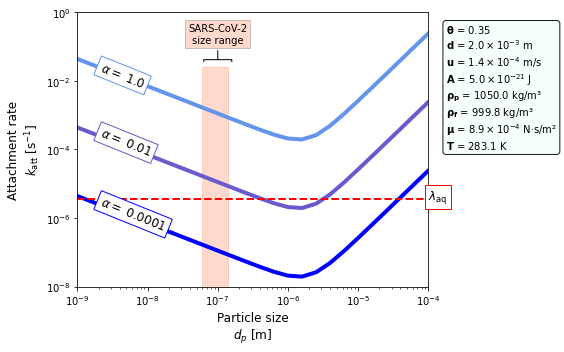

In [22]:
dp = np.power(10.,np.arange(-9,-2,0.2))
dc = 2.0E-3 # 2mm << sand
dpVirus = [60.0E-9, 140.0E-9] #Measured sarscov2
dpFloc = 10.0E-6 #A floc?

plt.figure(figsize=(8,5),facecolor="white")
ax1 = plt.subplot(1,1,1)

## Sizes of POM
#ax1.axvspan(1.0E-9,1.0E-6,ymax=1,\
#            label="Dissolved solids",\
#            color="seagreen",alpha=0.1)

#ax1.axvspan(1.0E-6,1.0E-4,ymax=1,\
#            label="Suspended solids",\
#            color="teal",alpha=0.1)

#ax1.axvline(x=100.0E-6,ymax=1,\
#            label="Settleable solids",\
#            ls="dashed",lw=2,c="teal")

## Efficiency 100%
alpha = 1.00
kAtt = kattFromdp(dp)
ax1.plot(dp,kAtt,lw=4,c="cornflowerblue")

rotang = -22.0
bbox = dict(boxstyle='square', fc='white', ec='cornflowerblue')
ax1.text(2.0E-9,kAtt[0]*0.15,r'$\alpha =$ '+'{:}'.format(alpha),
         fontsize=12,rotation=rotang,bbox=bbox)

## Efficiency 1%
alpha = 0.01
kAtt = kattFromdp(dp)
ax1.plot(dp,kAtt,lw=4,c="slateblue")

bbox = dict(boxstyle='square', fc='white', ec='slateblue')
ax1.text(2.0E-9,kAtt[0]*0.15,r'$\alpha =$ '+'{:}'.format(alpha),
         fontsize=12,rotation=rotang,bbox=bbox)

## Efficiency 0.01%
alpha = 0.0001
kAtt = kattFromdp(dp)
ax1.plot(dp,kAtt,lw=4,c="blue")

bbox = dict(boxstyle='square', fc='white', ec='blue')
ax1.text(2.0E-9,kAtt[0]*0.10,r'$\alpha =$ '+'{:}'.format(alpha),
         fontsize=12,rotation=rotang,bbox=bbox)

## Virus size
ax1.axvspan(dpVirus[0],dpVirus[1],ymax=0.8,\
            color="orangered",alpha=0.20)

ax1.annotate('SARS-CoV-2\nsize range', xy=(0.4, 0.82), xytext=(0.4, 0.92), xycoords='axes fraction', 
            fontsize=10, ha='center', va='center',
            bbox=dict(boxstyle='square', fc='orangered',alpha=0.20),
            arrowprops=dict(arrowstyle='-[, widthB=1.4, lengthB=0.2', lw=1.0))


## Decay rate 
ax1.axhline(y=decayRate,\
            ls="dashed",lw=2,c="red")

bbox = dict(boxstyle='square', fc='white', ec='red')
ax1.text(1.E-4,decayRate,r"$\lambda_{\rm aq}$",\
         fontsize=12,bbox=bbox)

## Parameter info:
information = \
    r"$\bf{\theta}$" + " = {:.2f} ".format(theta) + "\n"\
    r"$\bf{d}$ = " + sci_notation(dc) + " m\n"\
    r"$\bf{u}$ = " + sci_notation(uChar()) + " m/s\n"\
    r"$\bf{A}$ = " + sci_notation(A) + " J\n"\
    r"$\bf{\rho_p}$ = " + "{:.1f}".format(particle_density) + " kg/m³\n"\
    r"$\bf{\rho_f}$ = " + "{:.1f}".format(water_density) + " kg/m³\n"\
    r"$\bf{\mu}$ = " + sci_notation(viscosity) + " N·s/m²\n"\
    r"$\bf{T}$ = " + "{:.1f}".format(TEMP) + " K" 

bbox = dict(boxstyle='round', facecolor='mintcream', alpha=0.90)
ax1.text(1.05,0.5,information,bbox=bbox,transform=ax1.transAxes)

## Miscelaneous
ax1.set(xscale='log',yscale='log')
ax1.set(xlim=[1.0E-9,1.0E-4],ylim=[1.0E-8,1.0E0])
font = {'size': 12}
ax1.set_ylabel("Attachment rate\n"+r"$k_{\rm att}$ [s$^{-1}$]",fontdict=font)
ax1.set_xlabel("Particle size\n$d_p$ [m]",fontdict=font)

## Legend
#ax1.legend(loc="lower left",ncol=1,bbox_to_anchor=(1.05, 0),\
#           title="$d_c = $" + "{:.1E} m".format(dc),\
#           title_fontsize="large")

plt.tight_layout()
plt.show()

## Plot collector size v. attachment rate 

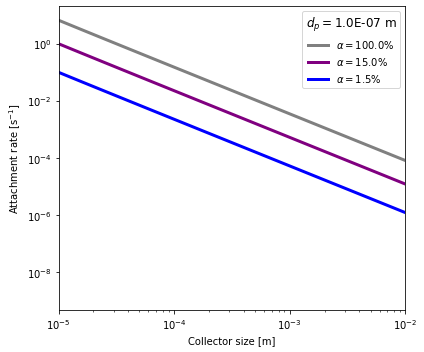

In [21]:
dc = np.power(10.,np.arange(-5,0,0.2))
dp = 100.0E-9 #A sarscov2?

plt.figure(figsize=(6,5),facecolor="white")
ax1 = plt.subplot(1,1,1)
## Efficiency 100%
alpha = 1.00
K = kattFromdp(dp)
ax1.plot(dc,K,lw=3,c="gray",\
         label="$\\alpha = $"+"{:.1f}%".format(alpha*100))
## Different efficiencies
alpha = 0.15
K = kattFromdp(dp)
ax1.plot(dc,K,lw=3,c="purple",\
         label="$\\alpha = $"+"{:.1f}%".format(alpha*100))

alpha = 0.015
K = kattFromdp(dp)
ax1.plot(dc,K,lw=3,c="blue",\
         label="$\\alpha = $"+"{:.1f}%".format(alpha*100))

## Miscelaneous
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_ylabel("Attachment rate [s$^{-1}$]")
ax1.set_xlabel("Collector size [m]")
ax1.set_xlim(1.0E-5,1.0E-2)
#ax1.set_ylim(2.0E-4,2.0E+2)

## Legend
ax1.legend(loc="best",\
           title="$d_p = $" + "{:.1E} m".format(dp),\
           title_fontsize="large")

plt.tight_layout()
plt.show()

## Plot collector size v. attachment rate 

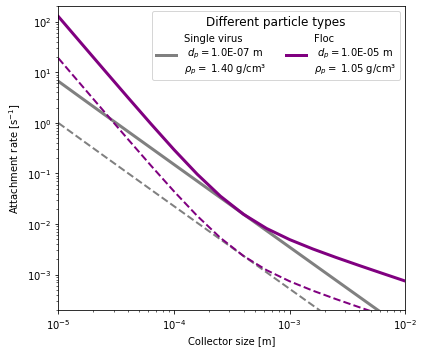

In [22]:
dc = np.power(10.,np.arange(-5,0,0.2))

plt.figure(figsize=(6,5),facecolor="white")
ax1 = plt.subplot(1,1,1)

## Individual virus
alpha = 1.00
dp = 100.0E-9 #A sarscov2
particle_density=1400
K = kattFromdp(dp)
ax1.plot(dc,K,lw=3,c="gray",\
         label="Single virus\n $d_p = $" + "{:.1E} m".format(dp)\
         + "\n$\\rho_p = $" + " {:.2f} g/cm³".format(particle_density/1000))

dp = 10.0E-6 #A biomass floc
particle_density=1050
K = kattFromdp(dp)
ax1.plot(dc,K,lw=3,c="purple",\
         label="Floc\n $d_p = $" + "{:.1E} m".format(dp)\
         + "\n$\\rho_p = $" + " {:.2f} g/cm³".format(particle_density/1000))

## Individual virus
alpha = 0.15
dp = 100.0E-9 #A sarscov2
particle_density=1400
K = kattFromdp(dp)
ax1.plot(dc,K,lw=2,c="gray",ls='dashed')

dp = 10.0E-6 #A biomass floc
particle_density=1050
K = kattFromdp(dp)
ax1.plot(dc,K,lw=2,c="purple",ls='dashed')


## Miscelaneous
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_ylabel("Attachment rate [s$^{-1}$]")
ax1.set_xlabel("Collector size [m]")
ax1.set_xlim(1.0E-5,1.0E-2)
ax1.set_ylim(2.0E-4,2.0E+2)

## Legend
ax1.legend(loc="best",\
           title="Different particle types",\
           title_fontsize="large",\
           ncol=2)

plt.tight_layout()
plt.show()

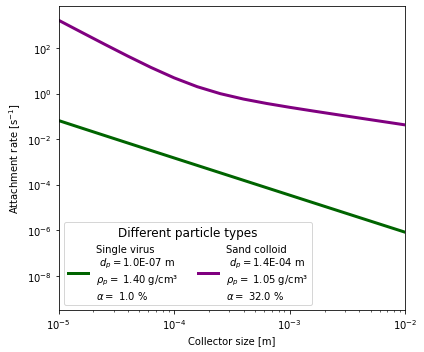

In [50]:
dc = np.power(10.,np.arange(-5,0,0.2))

plt.figure(figsize=(6,5),facecolor="white")
ax1 = plt.subplot(1,1,1)

## Individual virus
alpha = 0.01 #Over SiO2
dp = 100.0E-9 #A sarscov2
particle_density=1400
K = kattFromdp(dp)
ax1.plot(dc,K,lw=3,c="darkgreen",\
         label="Single virus\n $d_p = $" + "{:.1E} m".format(dp)\
         + "\n$\\rho_p = $" + " {:.2f} g/cm³".format(particle_density/1000)
         + "\n$\\alpha = $" + " {:.1f} %".format(alpha*100))

## A sand colloid
alpha = 0.32 #Check ren & packman - 2000
dp = 137.0E-6 #A #100 sand colloid
particle_density=1050
K = kattFromdp(dp)
ax1.plot(dc,K,lw=3,c="purple",\
         label="Sand colloid\n $d_p = $" + "{:.1E} m".format(dp)\
         + "\n$\\rho_p = $" + " {:.2f} g/cm³".format(particle_density/1000)
         + "\n$\\alpha = $" + " {:.1f} %".format(alpha*100))

## Miscelaneous
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_ylabel("Attachment rate [s$^{-1}$]")
ax1.set_xlabel("Collector size [m]")
ax1.set_xlim(1.0E-5,1.0E-2)
#ax1.set_ylim(2.0E-4,2.0E+2)

## Legend
ax1.legend(loc="best",\
           title="Different particle types",\
           title_fontsize="large",\
           ncol=2)

plt.tight_layout()
plt.show()

### Flow velocity v. attachment rate

In [51]:
'''CASE CONSTANTS'''
#Porosity
theta = 0.37 # adim

#Collector diameter
dc = 2.0E-3 # 2mm << sand

#Particle diameter
dp = 1.0E-7 # 100nm << particle

#Hamaker constant
A = 5.0E-21 # J = N·m

#Water dynamic viscosity
viscosity = 0.0008891 # N·s/m²

#Densities
water_density = 997.05 # kg/m³
particle_density = 1050.0 # kg/m³ 

#Collision/attachment efficiency
alpha = 1.00 # adim << favorable conditions

#Darcy flow velocity
q = np.power(10.,np.arange(-50,-2,1)) # 0.0001 # m/s 

In [52]:
def kattFromdp():

    #Molecular diffusion
    Dm  = molecularDiff(viscosity,dp)
    
    #Pore water velocity
    U   = poreVel(q,theta)

    #Non-dimensional numbers
    As  = happelParameter(theta)
    NR  = noDim_SizeRatio(dp,dc)
    NPe = noDim_Péclet(q,dc,Dm)
    NvW = noDim_vanderWaals(A)
    NGr = noDim_Gravitational(dp,water_density,particle_density)
    
    #Collector efficiency
    etaD = collectorEfficiency_Diffusion(As,NR,NPe,NvW)
    etaI = collectorEfficiency_Interception(As,NR,NPe,NvW)
    etaG = collectorEfficiency_GDeposition(NGr,NR,NPe,NvW)
    eta0 = collectorEff(etaD,etaI,etaG)
    
    #Attachment rate
    kAtt = attachmentRate(dc,theta,alpha,U,eta0)
    
    #Print report
    if(True):
        print("Molecular diffusion coef:",Dm)
        print("Darcy velocity:          ",q)
        print("Pore-water velocity:     ",U)
        print("\n")
        print("Happel parameter:",As)
        print("NR number:       ",NR)
        print("NPe number:      ",NPe)
        print("NvW number:      ",NvW)
        print("NGr number:      ",NGr)
        print("\n")
        print("etaD collector:  ",etaD)
        print("etaI collector:  ",etaI)
        print("etaG collector:  ",etaG)
        print("eta0 collector:  ",eta0)
        
    return kAtt

Molecular diffusion coef: 4.66528523204759e-12
Darcy velocity:           [1.e-50 1.e-49 1.e-48 1.e-47 1.e-46 1.e-45 1.e-44 1.e-43 1.e-42 1.e-41
 1.e-40 1.e-39 1.e-38 1.e-37 1.e-36 1.e-35 1.e-34 1.e-33 1.e-32 1.e-31
 1.e-30 1.e-29 1.e-28 1.e-27 1.e-26 1.e-25 1.e-24 1.e-23 1.e-22 1.e-21
 1.e-20 1.e-19 1.e-18 1.e-17 1.e-16 1.e-15 1.e-14 1.e-13 1.e-12 1.e-11
 1.e-10 1.e-09 1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03]
Pore-water velocity:      [2.7027027e-50 2.7027027e-49 2.7027027e-48 2.7027027e-47 2.7027027e-46
 2.7027027e-45 2.7027027e-44 2.7027027e-43 2.7027027e-42 2.7027027e-41
 2.7027027e-40 2.7027027e-39 2.7027027e-38 2.7027027e-37 2.7027027e-36
 2.7027027e-35 2.7027027e-34 2.7027027e-33 2.7027027e-32 2.7027027e-31
 2.7027027e-30 2.7027027e-29 2.7027027e-28 2.7027027e-27 2.7027027e-26
 2.7027027e-25 2.7027027e-24 2.7027027e-23 2.7027027e-22 2.7027027e-21
 2.7027027e-20 2.7027027e-19 2.7027027e-18 2.7027027e-17 2.7027027e-16
 2.7027027e-15 2.7027027e-14 2.7027027e-13 2.7027027e-12 2.702

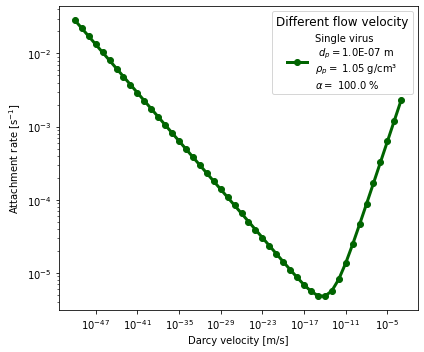

In [22]:
plt.figure(figsize=(6,5),facecolor="white")
ax1 = plt.subplot(1,1,1)

## Individual virus
K = kattFromdp()
ax1.plot(q,K,lw=3,c="darkgreen",marker='o',\
         label="Single virus\n $d_p = $" + "{:.1E} m".format(dp)\
         + "\n$\\rho_p = $" + " {:.2f} g/cm³".format(particle_density/1000)
         + "\n$\\alpha = $" + " {:.1f} %".format(alpha*100))

## Miscelaneous
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_ylabel("Attachment rate [s$^{-1}$]")
ax1.set_xlabel("Darcy velocity [m/s]")
#ax1.set_xlim(1.0E-5,1.0E-2)
#ax1.set_ylim(2.0E-4,2.0E+2)

## Legend
ax1.legend(loc="best",\
           title="Different flow velocity",\
           title_fontsize="large",\
           ncol=2)

plt.tight_layout()
plt.show()

___________

# Collision/Attachment efficiency

\begin{equation}
    \alpha = 
    \dfrac{\text{Rate at which particles attach to the collector}}
        {\text{Rate at which particles collide with the collector}}
    \quad
    \propto
    \quad
    \exp\left(-|\Phi_{max}|\right)
\end{equation}    

### Soil geochemical heterogenity
Elimelech et al. (2000) [10.1021/es9910309](https://pubs.acs.org/doi/10.1021/es9910309)

\begin{equation}
    \alpha = \lambda 
\end{equation}

- $\lambda$ : proportion of favorable (oppositely charged) sites in the collector to total number of sites for attachment

### Interaction Force Boundary Layer

\begin{equation}
    \alpha = \left(\dfrac{\beta}{1+\beta}\right)S(\beta)
\end{equation}

\begin{equation}
    \beta = \dfrac{\sqrt[3]{2}}{3}\Gamma{(1/3)}A_s^{-1/3}\left(\dfrac{D_m}{ur_c}\right)^{1/3}\left(\dfrac{K_Fr_c}{D_m}\right)
\end{equation}

\begin{equation}
    K_F = D_m \left[\int_0^\infty
        \left( f(x,r_p) \exp\left(\dfrac{\Phi_T}{k_BT}\right)-1
        \right) dx \right]^{-1}
\end{equation}

\begin{equation}
    f(x,r_p) = 1 + \dfrac{r_p}{x}
\end{equation}


### Maxwell Model

\begin{equation}
    \alpha = \alpha_{\rm pri} + \alpha_{\rm sec}
\end{equation}

- $\alpha_{\rm pri}$ : attachment efficiency of particles in the primary minimum on the DLVO interaction
- $\alpha_{\rm sec}$ : attachment efficiency of particles in the secondary minimum on the DLVO interaction

\begin{equation}
    \alpha_{\rm pri} = \int_{\sqrt{\Delta\Phi}}^{\infty}\left[
        \dfrac{4}{\sqrt{\pi}}\chi^2\exp\left(-\chi^2\right)
    \right]d\chi
\end{equation}

\begin{equation}
    \alpha_{\rm sec} = \int_{0}^{\sqrt{\Phi_{\rm \sec}}}\left[
        \dfrac{4}{\sqrt{\pi}}\chi^2\exp\left(-\chi^2\right)
    \right]d\chi
\end{equation}

- $\Phi_{\rm sec}$ : DLVO interaction energy at the secondary minimum
- $\Delta\Phi$ : Energy barrier towards the primary minimum. It is the difference between the DLVO interaction energy at the secondary minimum and the maximum
- $\chi$ : dimensionless kinetic energy of a particle

\begin{equation}
    \chi^2 = \dfrac{m_p v^2}{2k_BT}
\end{equation}

- $m_p$ : mass of the particle
- $v$ : velocity of the particle (check Maxwell-Boltzmann distribution)

\begin{equation}
    \alpha = 1 - \int_{\sqrt{\Phi_{\rm sec}}}^{\sqrt{\Delta\Phi}}\left[
        \dfrac{4}{\sqrt{\pi}}\chi^2\exp\left(-\chi^2\right)
    \right]d\chi
\end{equation}